In [128]:
import os
import pandas as pd
import umap

from pathlib import Path

import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import logging

import matplotlib.pyplot as plt
from cycler import cycler

from torchvision import transforms
from torchvision.transforms import v2

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import pytorch_metric_learning
from pytorch_metric_learning import miners, losses, testers, trainers
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

## TODO:
- [x] Visualize datapoints from the torch.Dataset
- [ ] Visualize some triplets (to make sure it gets harder and harder)
- [ ] Visualize the embeddings to make sure it gets better clustered
- [ ] UMAP and t-SNE on train set and test set
- [ ] Hyperparameter tuning
- [ ] Add evaluation metrics using AccuracyCalculator for instance, using precision_at_k
- [ ] split into trunk and embedder
- [ ] Add a visualizer hook after each epoch
- [ ] Have an optimizer different for trunk and embedder
- [ ] Hyperparameter tuning
- [ ] Make it work with tensorboard
- [ ] Missing normalization from ImageNet
- [ ] Use a Sampler MPerClass to balance the dataset and metric learning

In [129]:
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.4.1


## Loading the Dataset

In [130]:
dataset_size = "nano"

datasplit_filepath = Path(f"../../../data/04_feature/bearidentification/bearid/data_split/by_individual/{dataset_size}/data_split.csv")

df = pd.read_csv(datasplit_filepath, sep=";")
df_train = df[df["split"] == "train"]
df_test = df[df["split"] == "test"]

In [131]:
df.head()

,origin,encounter,bear_id,image,path_data_relative,path,split
0,brooksFalls,je_201708,bf_480,480-otis_14592316682_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
1,brooksFalls,je_201708,bf_480,480-otis_10234355613_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
2,brooksFalls,je_201708,bf_480,480-otis_9382835168_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
3,brooksFalls,je_201708,bf_480,480-otis-in-far-pool_11332560345_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
4,brooksFalls,je_201708,bf_480,480-otis_10234289115_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   origin              1040 non-null   object
 1   encounter           1040 non-null   object
 2   bear_id             1040 non-null   object
 3   image               1040 non-null   object
 4   path_data_relative  1040 non-null   object
 5   path                1040 non-null   object
 6   split               1040 non-null   object
dtypes: object(7)
memory usage: 57.0+ KB


In [133]:
df_train

,origin,encounter,bear_id,image,path_data_relative,path,split
0,brooksFalls,je_201708,bf_480,480-otis_14592316682_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
1,brooksFalls,je_201708,bf_480,480-otis_10234355613_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
2,brooksFalls,je_201708,bf_480,480-otis_9382835168_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
3,brooksFalls,je_201708,bf_480,480-otis-in-far-pool_11332560345_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
4,brooksFalls,je_201708,bf_480,480-otis_10234289115_o.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
...,...,...,...,...,...,...,...
640,brooksFalls,bear_mon_201507,bf_151,P1190809.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
641,brooksFalls,bear_mon_201507,bf_151,P1200791.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
642,brooksFalls,bear_mon_201507,bf_151,P1190807.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train
643,brooksFalls,bear_mon_201507,bf_151,P1200799.jpg,data/07_model_output/bearfacesegmentation/chip...,../../../data/07_model_output/bearfacesegmenta...,train


In [134]:
# Miner expects labels as tensor, so we must create a mapping between bear_ids and some integer
id_mapping = pd.DataFrame(list(enumerate(df["bear_id"].unique())), columns=["id", "label"])

In [135]:
id_mapping

,id,label
0,0,bf_480
1,1,bf_775
2,2,bf_151
3,3,bf_409
4,4,bf_410


## Model data preparation

In [136]:
class BearCircleLossDataset(Dataset):
    def __init__(self, dataframe, id_mapping, transform=None):
        self.dataframe = dataframe
        self.id_mapping = id_mapping
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        image_path = sample.path
        bear_id = sample.bear_id

        id_value = self.id_mapping.loc[self.id_mapping['label'] == bear_id, 'id'].iloc[0]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, id_value

In [137]:
# Missing normalization from ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=0.1, saturation=(0.9, 1.1)),  # Taken from Dolphin ID
    v2.RandomRotation(10),  # Taken from Dolphin ID
    transforms.ToTensor(),
])

In [138]:
train_dataset = BearCircleLossDataset(df_train, id_mapping, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = BearCircleLossDataset(df_test, id_mapping, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

In [139]:
id_mapping.iloc[label]["label"]

'bf_480'

In [140]:
def visualize_dataset_sample(dataset, id_mapping, n: int = 5) -> None:
    for i in range(min(n, len(dataset))):
        data, label = dataset[i]
        bear_id = id_mapping.iloc[label]["label"]
        fig, ax = plt.subplot_mosaic([["sample"]], figsize = (3,3))
        ax["sample"].imshow(data.permute(1,2,0))
        ax["sample"].axis("off")
        ax["sample"].set_title(f"{bear_id}")
        plt.show()

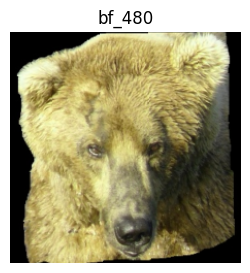

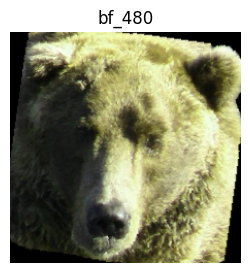

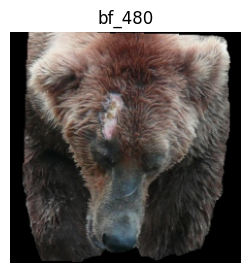

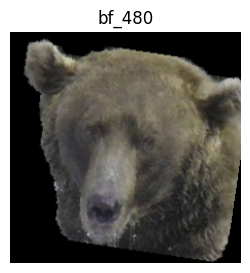

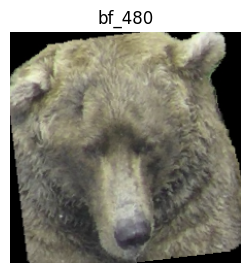

In [141]:
visualize_dataset_sample(dataset=train_dataset, id_mapping=id_mapping, n=5)

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Model

In [144]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)

hooks = logging_presets.get_hook_container(record_keeper)

tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=2,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=5)
    plt.show()

In [145]:
# Embedder model + Trunk model

# Load pre-trained resnet
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),  # From bottleneck layer to 1024 units
    nn.ReLU(),                      # ReLU activation
    nn.BatchNorm1d(1024),           # Batch Normalisation for the 1024-unit layer
    nn.Linear(1024, 128)            # From 1024 units to 128 units (without activation)
)
model.to(device);

/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [146]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [147]:
loss_func = losses.CircleLoss(m=0.4, gamma=256)
mining_func =  miners.BatchEasyHardMiner(pos_strategy="semihard", neg_strategy="hard")

In [148]:
def test(model, dataset_dict: dict, tester, epoch: int):
    return tester.test(dataset_dict=dataset_dict, epoch=epoch, trunk_model=model)


def train(model, optimizer, train_loader, dataset_dict: dict, epochs: int = 5) -> None:
    tester = testers.GlobalEmbeddingSpaceTester(
        end_of_testing_hook=hooks.end_of_testing_hook,
        visualizer=umap.UMAP(),
        visualizer_hook=visualizer_hook,
        dataloader_num_workers=2,
        accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
    )
    
    for epoch in tqdm(range(epochs), desc='Epoch', position=0, leave=True):
        
        epoch_loss = 0
        for batch, (inputs, ids) in enumerate(tqdm(train_loader, desc='Batch', position=1, leave=True)):
            inputs, ids = inputs.to(device), ids.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            indices_tuple = mining_func(outputs, ids)
            loss = loss_func(outputs, ids, indices_tuple)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        print(f"Epoch {epoch + 1} loss: ", epoch_loss)
        tester.test(dataset_dict=dataset_dict, epoch=1, trunk_model=model)

    if epoch % 10 == 0:
        pass # torch.save(model.state_dict(), f"/content/drive/MyDrive/circle_loss_1024x128_{epoch}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the train split


Epoch 1 loss:  1418.2669410705566



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.02it/s]
INFO:PML:Getting embeddings for the test split

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.12it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


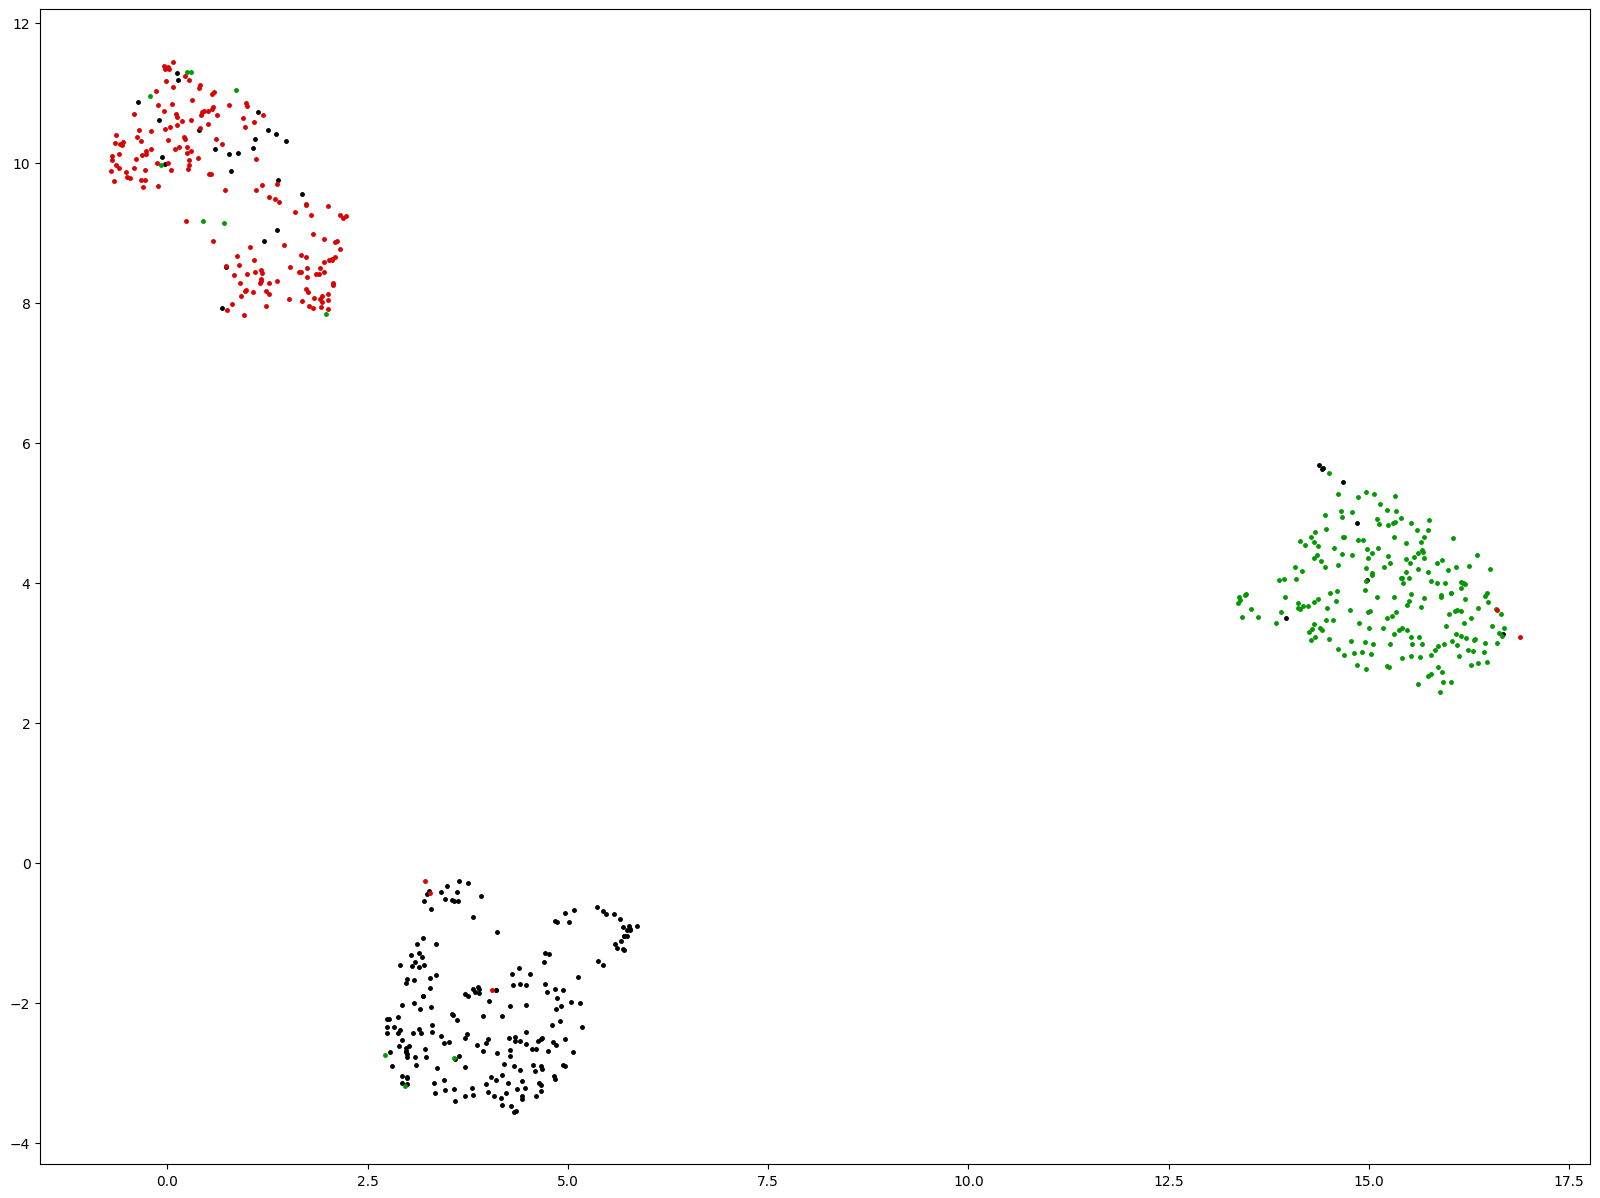

INFO:PML:Running UMAP on the test set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the test split and label set UMAP_level0


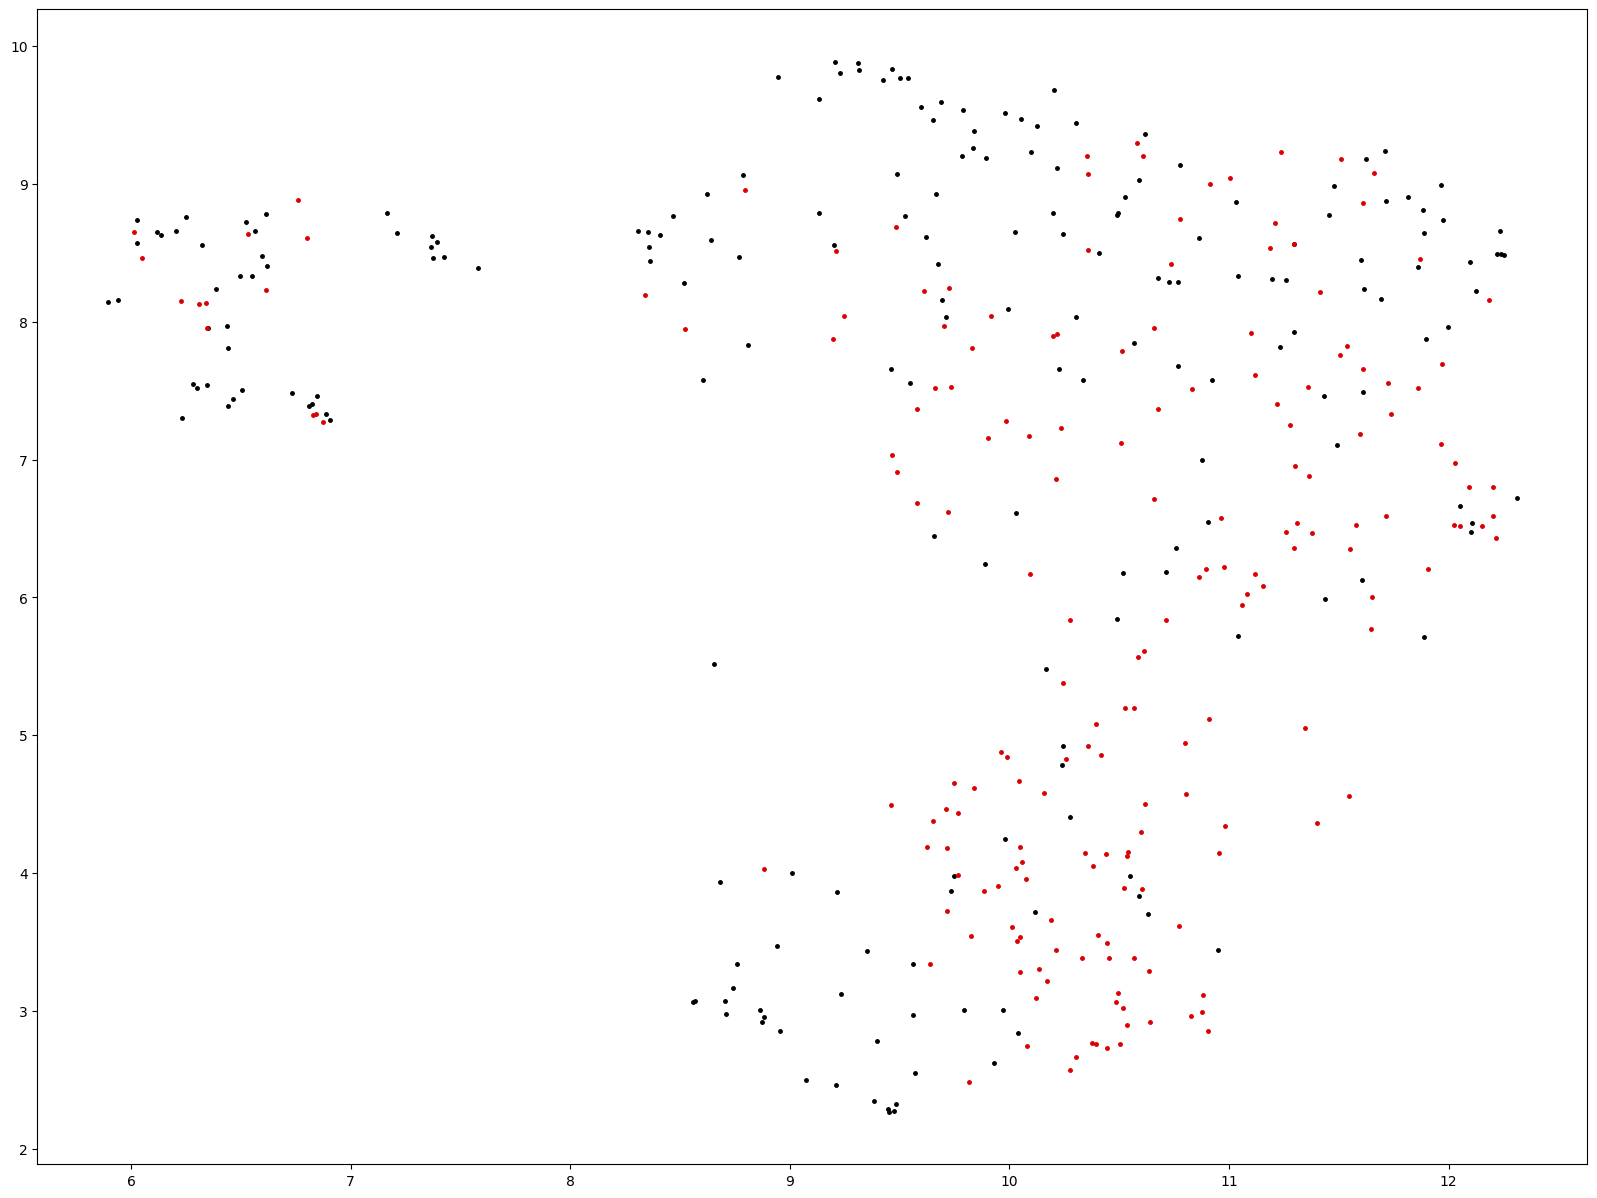

INFO:PML:Computing accuracy for the test split w.r.t ['test']
INFO:PML:running k-nn with k=204
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=2
INFO:PML:embedding dimensionality is 128
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=241
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=3
INFO:PML:embedding dimensionality is 128


Batch:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the train split


Epoch 2 loss:  805.2204580307007



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.12it/s]
INFO:PML:Getting embeddings for the test split

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


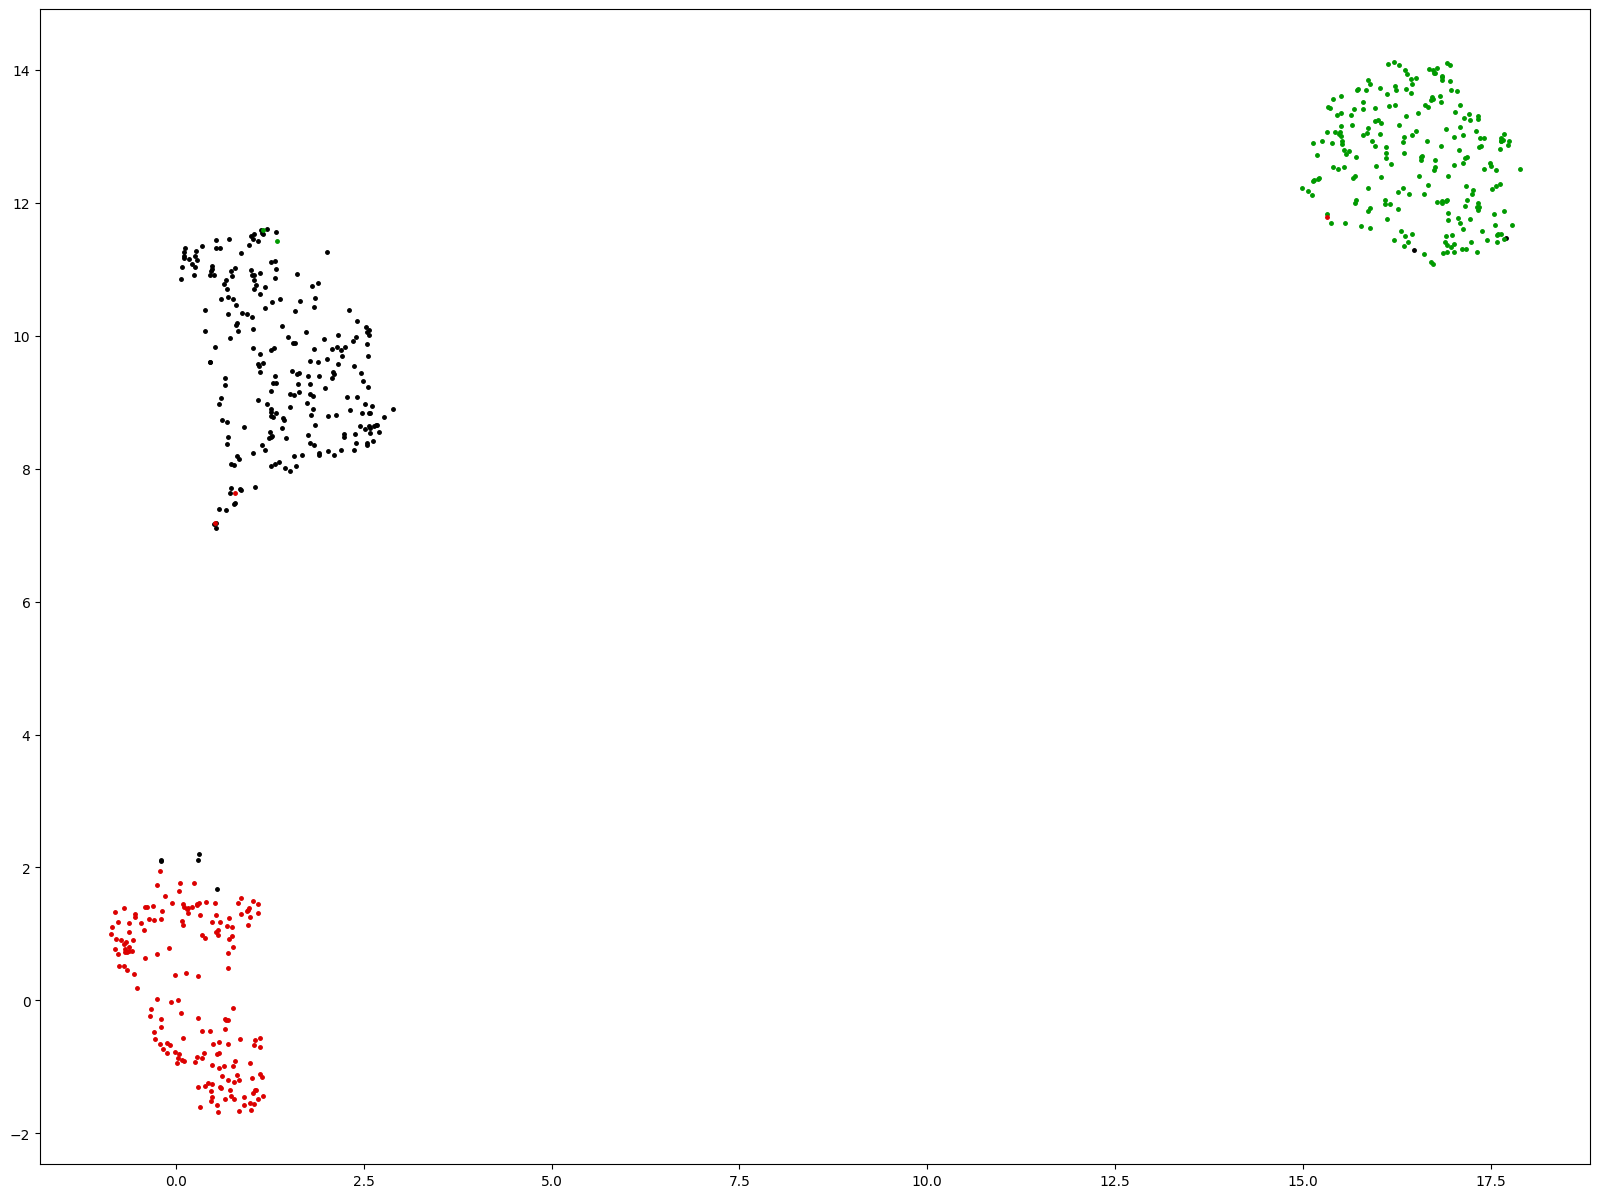

INFO:PML:Running UMAP on the test set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the test split and label set UMAP_level0


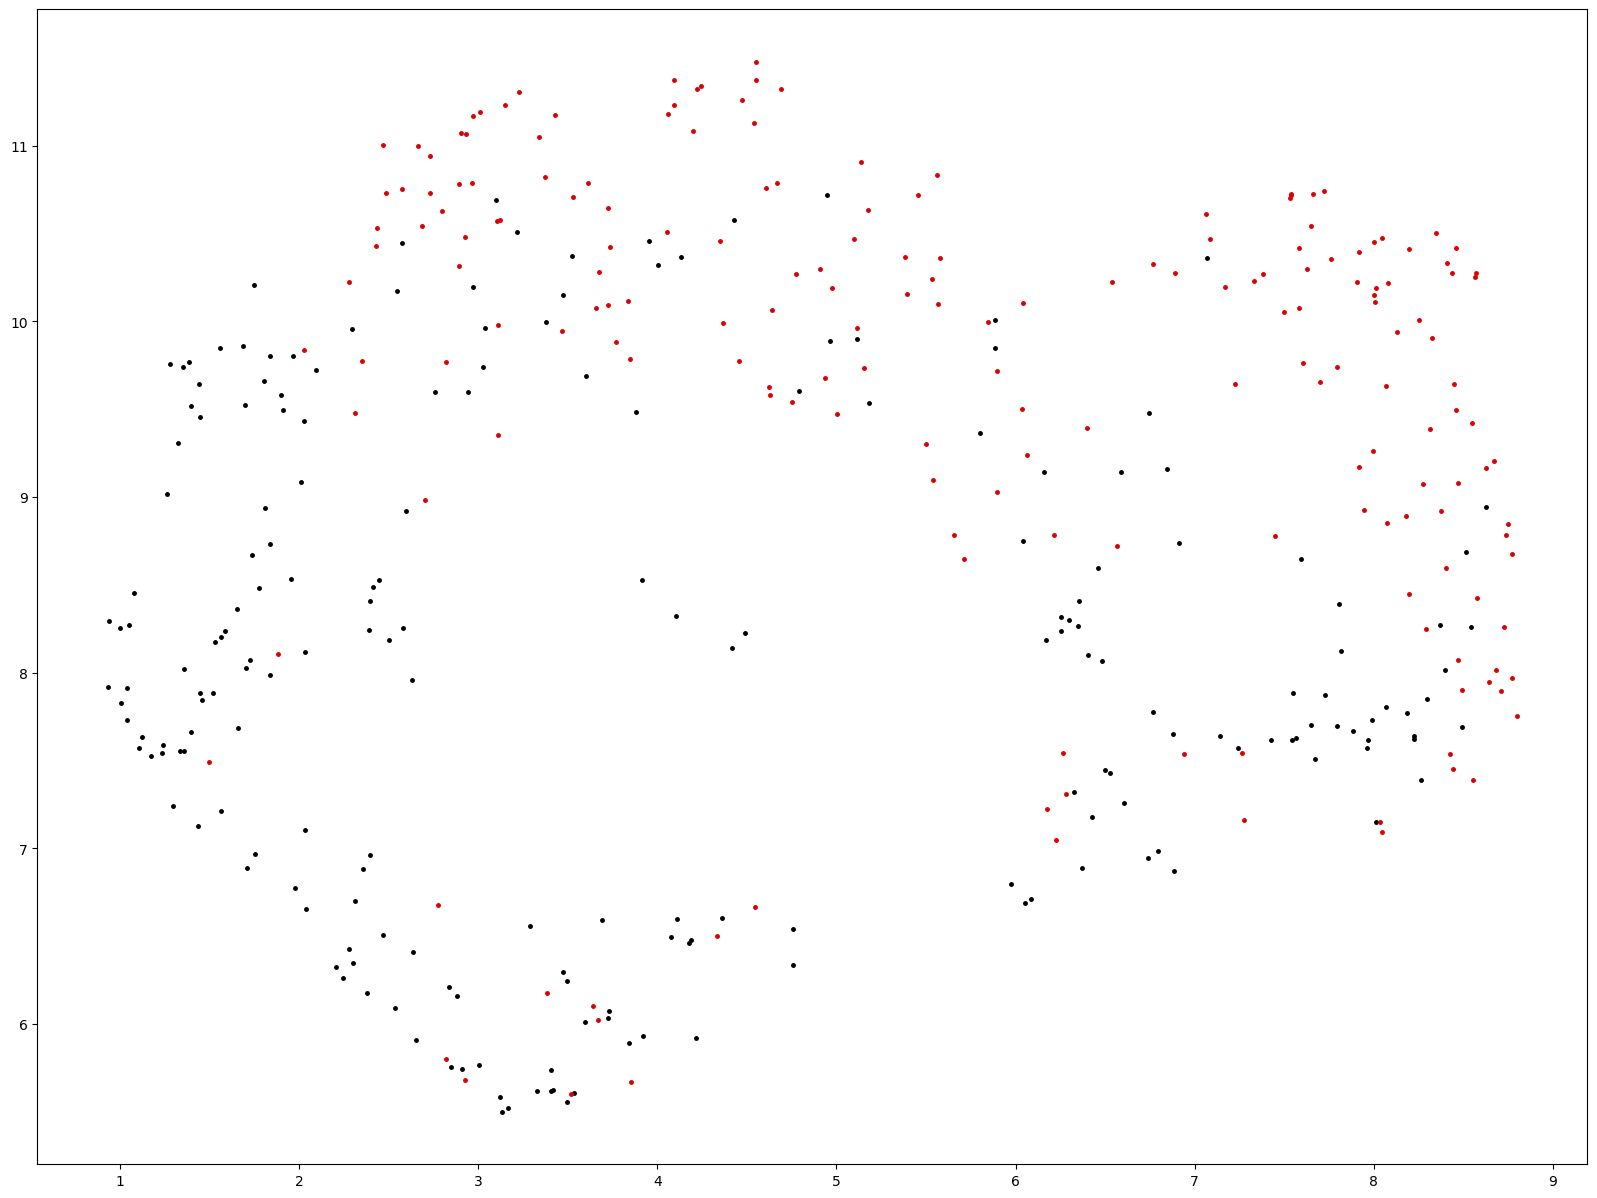

INFO:PML:Computing accuracy for the test split w.r.t ['test']
INFO:PML:running k-nn with k=204
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=2
INFO:PML:embedding dimensionality is 128
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=241
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=3
INFO:PML:embedding dimensionality is 128


Batch:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the train split


Epoch 3 loss:  296.1453446149826



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.10it/s]
INFO:PML:Getting embeddings for the test split

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.13it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


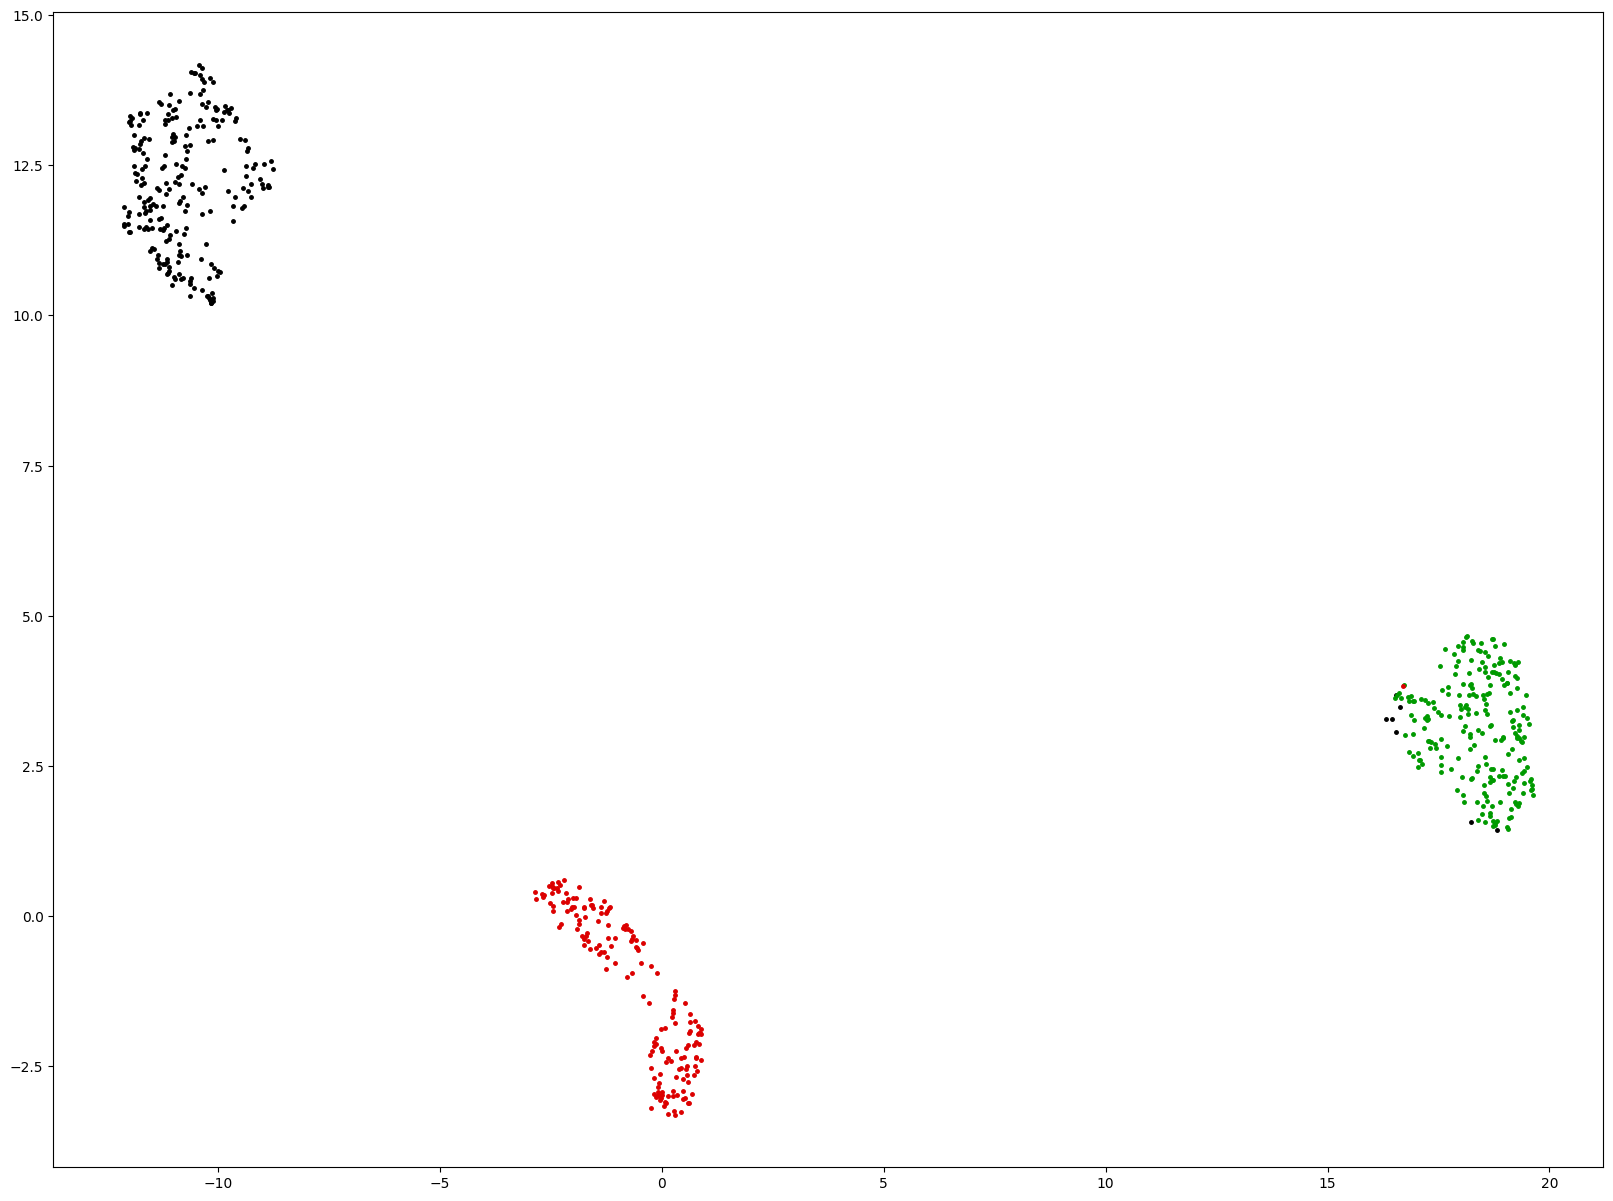

INFO:PML:Running UMAP on the test set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the test split and label set UMAP_level0


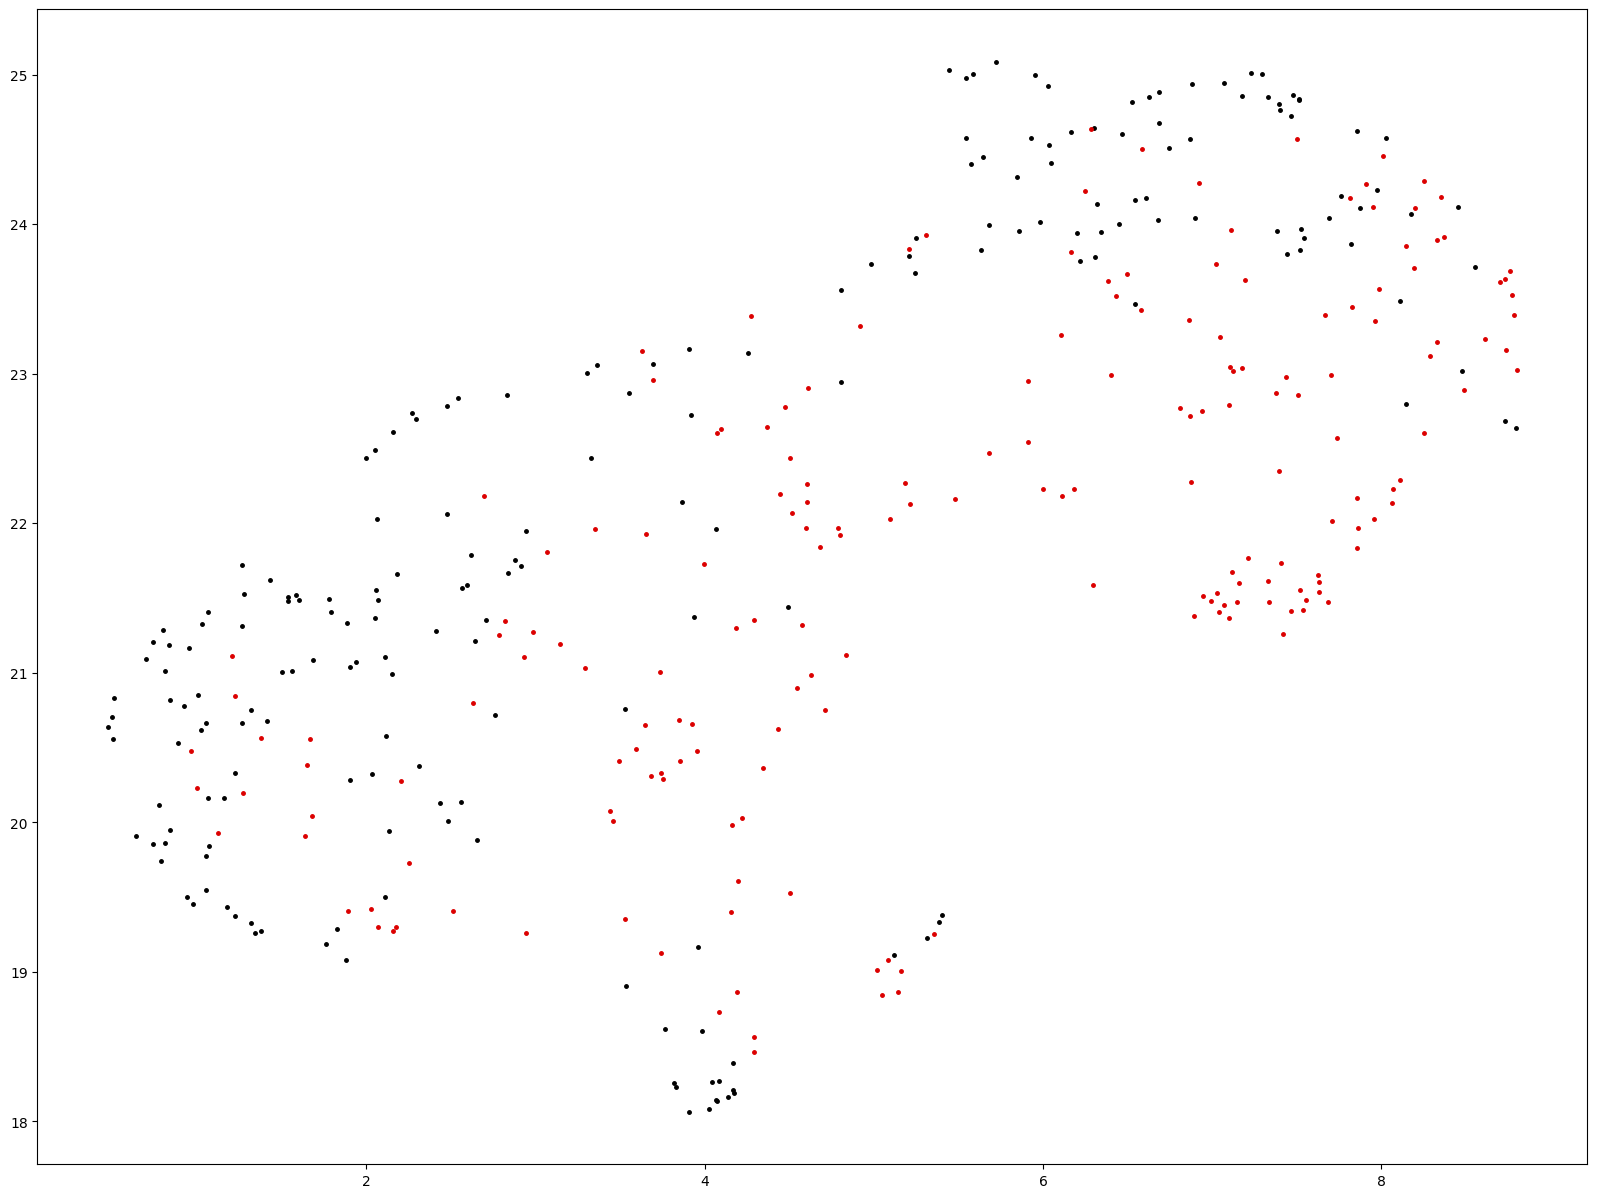

INFO:PML:Computing accuracy for the test split w.r.t ['test']
INFO:PML:running k-nn with k=204
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=2
INFO:PML:embedding dimensionality is 128
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=241
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=3
INFO:PML:embedding dimensionality is 128


In [149]:
writer = SummaryWriter()
epochs = 3
dataset_dict = {"test": test_dataset, "train": train_dataset}
train(model=model, optimizer=optimizer, train_loader=train_loader, dataset_dict=dataset_dict, epochs=epochs)
writer.close()

INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the train split
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.16it/s]
INFO:PML:Getting embeddings for the test split
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.12it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


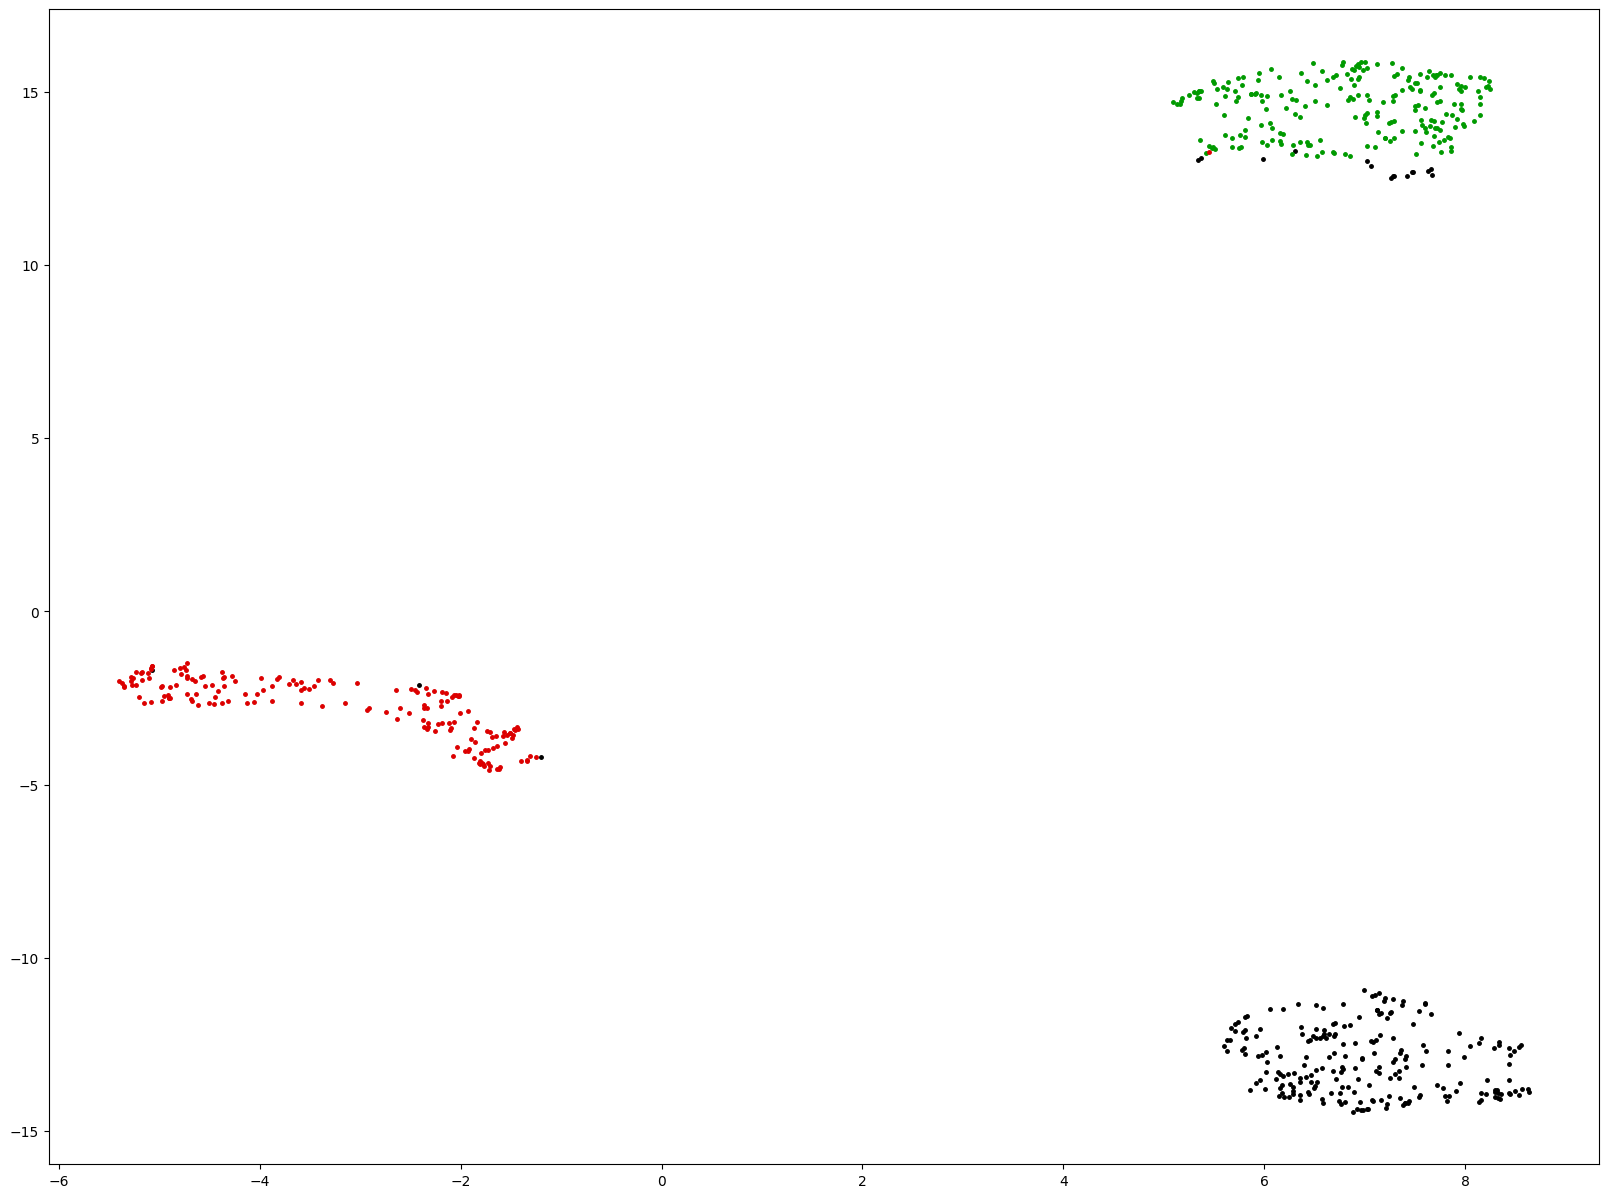

INFO:PML:Running UMAP on the test set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the test split and label set UMAP_level0


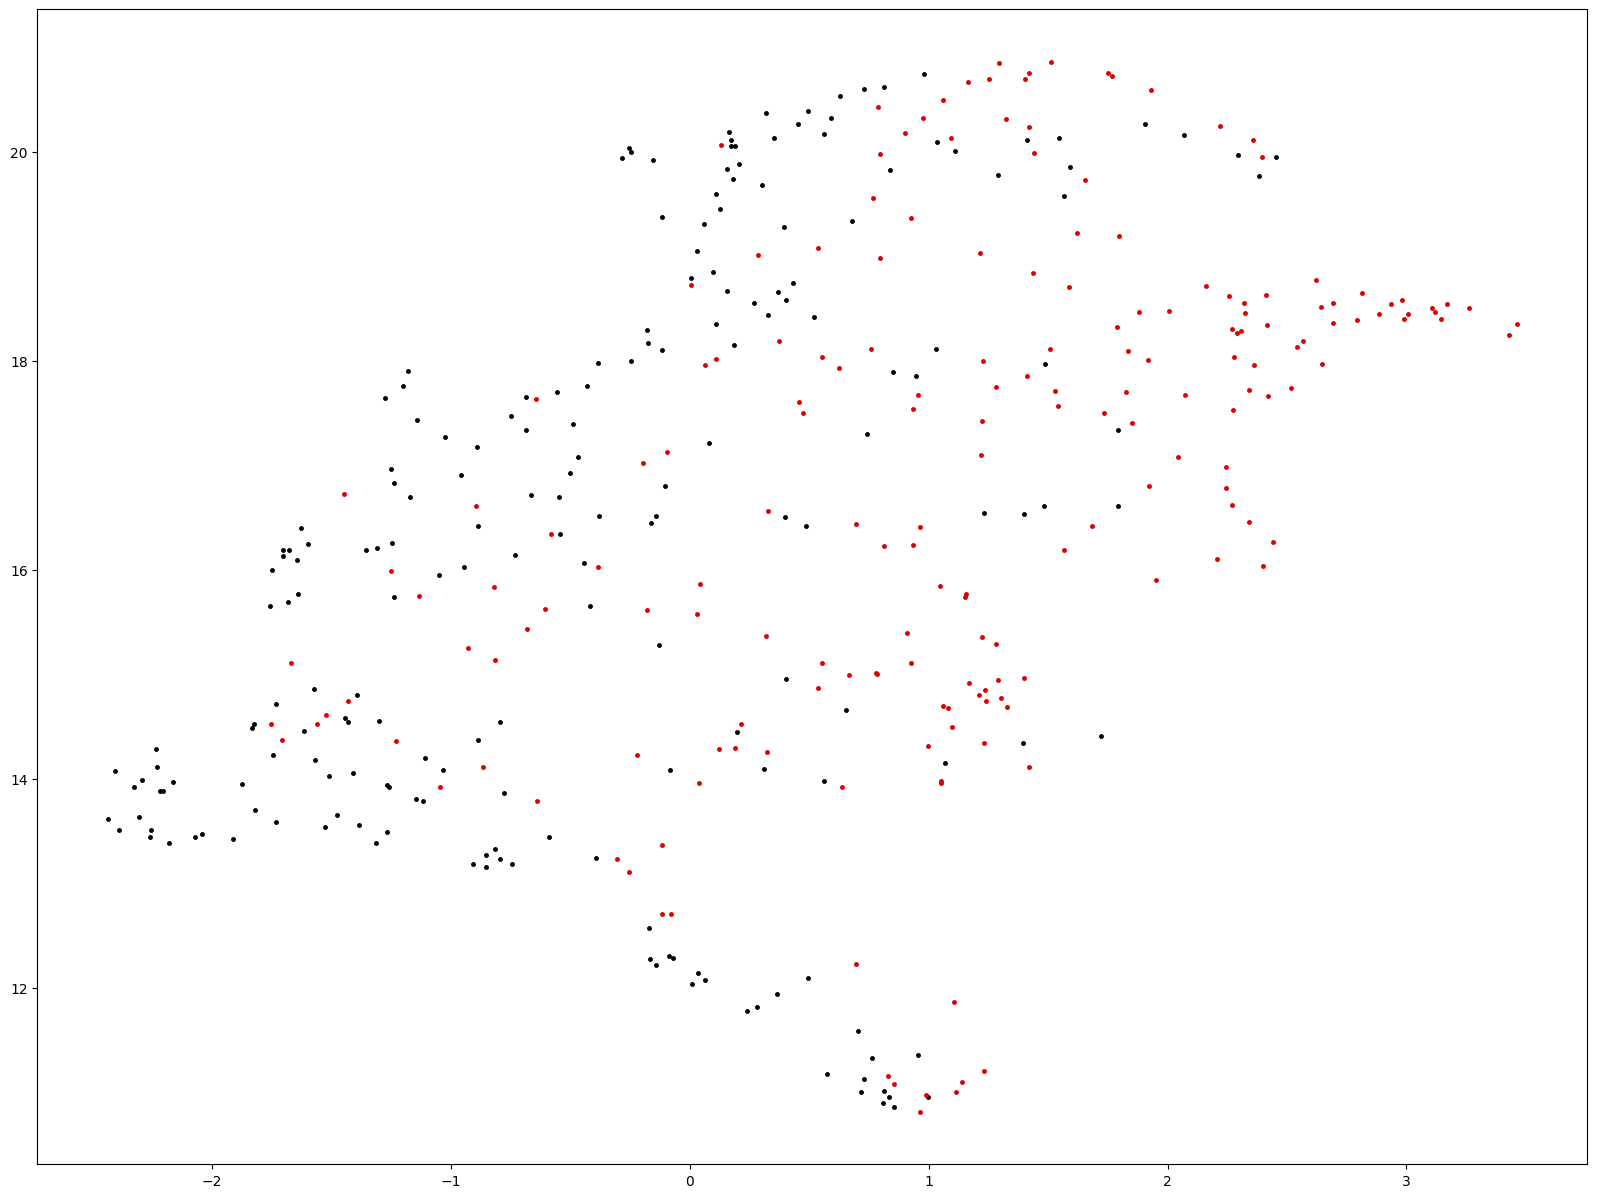

INFO:PML:Computing accuracy for the test split w.r.t ['test']
INFO:PML:running k-nn with k=204
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=2
INFO:PML:embedding dimensionality is 128
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=241
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=3
INFO:PML:embedding dimensionality is 128


defaultdict(dict,
            {'test': {'epoch': 1,
              'AMI_level0': 0.023363648640623166,
              'NMI_level0': 0.025155402017585128,
              'mean_average_precision_level0': 0.36483536069175715,
              'mean_average_precision_at_r_level0': 0.3557025783642376,
              'mean_reciprocal_rank_level0': 0.8927737474441528,
              'precision_at_1_level0': 0.8278481012658228,
              'r_precision_level0': 0.5442689438568048},
             'train': {'epoch': 1,
              'AMI_level0': 0.9022570162748481,
              'NMI_level0': 0.9025357992580109,
              'mean_average_precision_level0': 0.9583174759828177,
              'mean_average_precision_at_r_level0': 0.951412332517081,
              'mean_reciprocal_rank_level0': 0.986374020576477,
              'precision_at_1_level0': 0.9813953488372092,
              'r_precision_level0': 0.9561161330822348}})

In [151]:
tester = testers.GlobalEmbeddingSpaceTester(
        end_of_testing_hook=hooks.end_of_testing_hook,
        visualizer=umap.UMAP(),
        visualizer_hook=visualizer_hook,
        dataloader_num_workers=2,
        accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
    )

tester.test(dataset_dict=dataset_dict, epoch=1, trunk_model=model)